In [1178]:
#!g1.1
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import math
import torch.nn.functional as F
from IPython.display import clear_output

In [1179]:
#!g1.1
def KLD(x_true, p_true, x_pred, sig):
    batch_size, pNumber, _ = x_true.size()
    return 0.5 * np.log(2 * np.pi) - torch.logsumexp(p_true.view(batch_size, pNumber, 1) - net.square_dist(x_true, x_pred).squeeze(-1) / (2 * sig**2), dim=1).mean()

def sKLD(x_true, p_true, x_pred, sig):
    # symmetric KLD
    batch_size, pNumber, _ = x_true.size()
    inp1 = torch.logsumexp(p_true.view(batch_size, pNumber, 1) - net.square_dist(x_true, x_pred).squeeze(-1) / (2 * sig**2), dim=1).mean()
    p_pred = -np.log(pNumber)*torch.ones(batch_size, pNumber, 1).double().to(device)
    inp2 = pNumber * (p_true.exp()*torch.logsumexp(p_pred - net.square_dist(x_pred, x_true).squeeze(-1) / (2 * sig**2), dim=1)).mean()
    return -0.5 * (inp1 + inp2)

In [1180]:
#!g1.1
x_uni = torch.distributions.uniform.Uniform(low=-1, high=1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

hidden_dim = 32
batch_size = 1024
num_heads = 4
x_dim = 2
pNumber = 50

read_data = np.loadtxt('particles_data_'+str(x_dim)+'.csv', delimiter=',')
xp = read_data.reshape(read_data.shape[0] // pNumber, pNumber, x_dim + 1)

x1 = torch.from_numpy(xp[:, :, :-1]).double().to(device)
p1 = torch.from_numpy(xp[:, :, -1]).double().to(device)

OSError: particles_data_2.csv not found.

In [1181]:
#!g1.1
train_dataset = TensorDataset(x1[:int(0.7*len(xp))], p1[:int(0.7*len(xp))])
val_dataset = TensorDataset(x1[int(0.7*len(xp)):int(0.9*len(xp))], p1[int(0.7*len(xp)):int(0.9*len(xp))])
test_dataset = TensorDataset(x1[int(0.9*len(xp)):], p1[int(0.9*len(xp)):])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [1182]:
#!g1.1
def SDP_weight(k, v, q, weight):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(weight*attention, v)
    return values, attention

class MHA_weight(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.linear_k = nn.Linear(embed_dim, embed_dim)
        self.linear_v = nn.Linear(embed_dim, embed_dim)
        self.linear_q = nn.Linear(embed_dim, embed_dim)

    def forward(self, x1, x2, x3, weight, return_attention=False):
        k, v, q = self.linear_k(x1), self.linear_v(x2), self.linear_q(x3)
        batch_size, seq_length, embed_dim = x1.size()
        weight = weight.unsqueeze(2)
        weight = weight.repeat(1, 1, self.num_heads, 1)
        weight = weight.permute(0, 2, 1, 3)
        
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        q = self._reshape_to_batches(q)
        
        # Determine value outputs
        values, attention = SDP_weight(k, v, q, weight)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        out = self.o_proj(values)
        return out

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.num_heads
        return x.reshape(batch_size, seq_len, self.num_heads, sub_dim).permute(0, 2, 1, 3)

class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber):
        super(Encoder, self).__init__()
        self.num_particles = pNumber
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.x_dim = x_dim
        self.self_att1 = MHA_weight(self.hidden_dim, self.num_heads).double().to(device)

        self.output_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, 2*self.hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2*self.hidden_dim, self.hidden_dim)
            )

    def forward(self, x, p):
        # pointwise dense input layer
        weight = p.exp().unsqueeze(2).repeat(1, 1, self.num_particles)
        # weighted multihead attention
        x = self.self_att1(x, x, x, weight) + x
        # pointwise 2-layer feed-forward
        x = self.output_layer(x) + x
        return x#, x_min, x_max

class Decoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber):
        super(Decoder, self).__init__()
        self.num_particles = pNumber
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.x_dim = x_dim
        self.self_att1 = nn.MultiheadAttention(self.hidden_dim, self.num_heads, batch_first=True).double().to(device)
        self.att_weighted = MHA_weight(self.hidden_dim, self.num_heads).double().to(device)
        self.two_layers = nn.Sequential(
            nn.Linear(self.hidden_dim, 2*self.hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2*self.hidden_dim, self.hidden_dim),
            )

    def forward(self, x_enc, x_dec, p):
        y = self.self_att1(x_dec, x_dec, x_dec)[0] + x_dec
        weight = p.exp().unsqueeze(2).repeat(1, 1, self.num_particles)
        y = self.att_weighted(x_enc, x_enc, x_dec, weight) + y
        y = self.two_layers(y) + y
        return y

class Converter(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber, sig = 0.02, enc=Encoder(x_dim, hidden_dim, num_heads, pNumber), dec=Decoder(x_dim, hidden_dim, num_heads,pNumber)):
        super(Converter, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.first_linear = nn.Linear(self.x_dim, self.hidden_dim)
        self.last_linear = nn.Linear(self.hidden_dim, self.x_dim)
        self.num_particles = pNumber
        self.num_heads = num_heads
        self.enc = enc.double().to(device)
        self.dec = dec.double().to(device)

    def init_seed(self, batch_size):
        return torch.randn(batch_size, self.num_particles, self.hidden_dim).double().to(device)
    
    def forward(self, x0, p, eps=1e-12):
        mins, maxs = torch.amin(x0, dim=(1), keepdim=True), torch.amax(x0, dim=(1), keepdim=True)
        means = (mins + maxs) / 2
        delta = (maxs - mins)
        x0 = (x0 - means) / (delta + eps)
        x = self.first_linear(x0)
        x = self.enc(x, p)
        x = self.enc(x, p)
        batch_size = p.size(0)
        y = self.init_seed(batch_size)
        y = self.dec(x, y, p)
        y = self.dec(x, y, p)
        y0 = self.last_linear(y)
        loss = sKLD(x0, p, y0, sig)
        return y0 * (delta + eps) + means, loss

    def square_dist(self, x, y):
        D = torch.cdist(x, y, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')**2
        return D

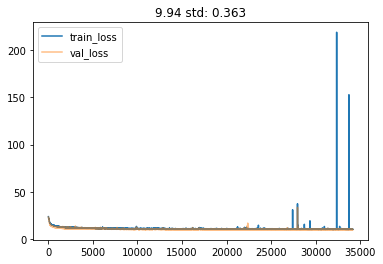

5it [00:00, 12.36it/s]


KeyboardInterrupt: 

In [1144]:
#!g1.1
epochs = 50000

sig = 0.02
net = Converter(x_dim, hidden_dim, num_heads, pNumber, sig).double().to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=1e-3)


train_loss = []
val_loss = []
best_loss = np.Inf
grad_clip = 5
for epoch in range(epochs):
    loss1_tot = 0
    loss2_tot = 0
    loss_tot = 0
    net.train()
    for i, xp1 in tqdm(enumerate(train_loader)):
        x1, p1 = xp1[0].to(device), xp1[1].to(device)
        opt.zero_grad()
        pred_x, loss = net(x1, p1)
        loss.backward()
        loss_tot += loss.item()
        torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    train_loss.append(loss_tot/(i+1))
    loss1_tot = 0
    loss2_tot = 0
    loss_tot = 0
    net.eval()
    for i, xp1 in enumerate(val_loader):
        with torch.no_grad():
            x1, p1 = xp1[0].to(device), xp1[1].to(device)
            pred_x, loss = net(x1, p1)
            loss_tot += loss.item()

    val_loss.append(loss_tot/(i+1))
    print(epoch, train_loss[-1], val_loss[-1])
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        state = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': opt.state_dict(),
        }
        torch.save(state, 'att_model'+str(x_dim)+'.ptm')

    if epoch > 10:
        clear_output(True)
        plt.figure()
        #ttl = str(np.round(best_loss, 2)) + ', loss1, loss2: ' + str(np.round(loss1_tot, 3)) + ' ' + str(np.round(loss2_tot, 3))
        plt.title(str(np.round(best_loss, 2)))
        plt.plot((train_loss[10:]), label='train_loss')
        plt.plot((val_loss[10:]), label='val_loss', alpha=0.5)
        plt.legend()
        plt.show()

In [1150]:
#!g1.1
def load_checkpoint(filepath='att_model'+str(x_dim)+'.ptm'):
    checkpoint = torch.load(filepath)
    print('epoch: ', checkpoint['epoch'])
    net.load_state_dict(checkpoint['state_dict'])
    for p in net.parameters():
        p.requires_grad = False
    net.eval()
    return net

net_read = Converter(x_dim, hidden_dim, num_heads, pNumber).double().to(device)
net_read = load_checkpoint()

net_read.eval()
loss1 = 0
for i, xp1 in enumerate(test_loader):
    with torch.no_grad():
        x1, p1 = xp1[0].to(device), xp1[1].to(device)
        batch_size = x1.size(0)
        pred_x, loss = net(x1, p1)
        loss1 += loss.item()
print('test loss', loss1 / (i+1))

epoch:  33474
test loss 10.014281626624056


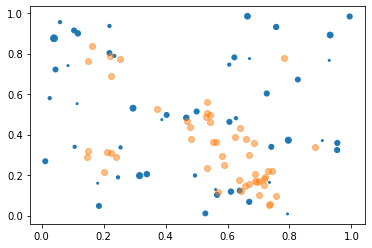

In [1177]:
#!g1.1
y_inp = np.array([x1[indx, :].to('cpu').numpy() for indx in range(x1.size(0))])
p_inp = np.array([p1[indx, :].to('cpu').numpy() for indx in range(p1.size(0))])
y_pred = np.array([pred_x[indx, :].to('cpu').numpy() for indx in range(pred_x.size(0))])
y_inp.shape, p_inp.shape, y_pred.shape

In [1175]:
#!g1.1
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
def to3d(x, y, z, w):
    w = w.reshape(w.shape[0], 1)
    res = np.array([(w[i]*np.exp(-((X-z[i, 0])**2+(Y-z[i, 1])**2)/(2*sig**2))) for i in range(50)]).sum(axis=0)
    return res
X, Y = np.meshgrid(x, y)
gaussian1 = to3d(X, Y, z1, w1)
gaussian2 = to3d(X, Y, z2, w2)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, gaussian1, color='blue', alpha=0.5, label='original particles')
ax.plot_surface(X, Y, gaussian2, color='orange', alpha=0.5, label='resampled particles')

In [1176]:
#!g1.1


In [ ]:
#!g1.1
